# Жолковский Евгений

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

# Реализация KMeans, KMeans++:

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


##класс KMeans--------------------------
class KMeans(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=0, init='random', eps=0.01):
    
        self.Nclusters = k #число кластеров
        self.Npoints = 1 #число точек в данных
        self.y = np.ones(1) #вектор принадлежности к классу
        self.metric = metric #метрика
        self.max_iter = max_iter #максимальное число итераций
        self.random_state = random_state #зернышко
        self.init = init #выбор начального расположение центроидов
        self.centroids = np.array((1)) #центроиды
        self.eps = eps #критерий остановки
        
    def distance(self, A, B):
        
        #евклидово расстояние
        if self.metric == 'euclidean':
            return sqrt( (A[0] - B[0])**2 + (A[1] - B[1])**2 )
    
    #выбор начальных координат центроидов
    def initial_clusters(self, X):
            
            #матрица расстояний
            dist = np.zeros((self.Nclusters, self.Npoints))
            
            #первый центроид
            self.centroids[0,:] = X[np.random.choice(xrange(self.Npoints), 1, replace=False),:]
            
            #оцениваем вероятности
            for k in xrange(self.Npoints):
                dist[0,k] = self.distance(X[k,:], self.centroids[0,:])
            
            #вектор вероятностей   
            proba = dist[0,:]**2 / sum(dist[0,:]**2)
            
            
            #теперь делаем для остальных кластеров
            for j in xrange(1, self.Nclusters):
                
                #выбираем точку, исходя из вероятностей
                self.centroids[j,:] = X[np.random.choice(xrange(self.Npoints), 1, replace=False, p = proba),:]
                
                
                #расстояния        
                for k in xrange(self.Npoints):
                    for i in xrange(self.Nclusters):
                        dist[i,k] = self.distance(X[k,:], self.centroids[i,:])
                
                
                #расстояние до ближайшего
                dist_nearest = np.zeros(self.Npoints)
                for k in xrange(self.Npoints):
                    dist_nearest[k] = min(dist[:,k])
                
                #вектор вероятностей 
                
                proba = np.array(cdist(X, self.centroids).min(axis=1) ** 2)
                proba = proba / sum(proba)
                #proba = dist_nearest**2 / sum(dist_nearest**2)
    
    
    def fit(self, X):

        self.Npoints = X.shape[0] #число точек
        self.dim = X.shape[1]
        np.random.seed(self.random_state) #зернышко
        self.y.resize(self.Npoints) #вектор с предсказаниями
        self.centroids = np.zeros((self.Nclusters,self.dim)) #инициализируем нулями

        #случайное начальное распределение
        if self.init == 'random':            
            self.centroids = np.random.rand(self.Nclusters,self.dim) #координаты центроидов
       
        #выбираем начальные приблежения
        if self.init == 'k-means':
            self.initial_clusters(X)
    
    
        #сохраняем предыдущее значение
        
        for j in xrange(self.max_iter):
            
            centroids_prev = self.centroids.copy()
            
            #классифицируем
            self.y = cdist(X, self.centroids).argmin(axis=1)
            
            #перераспределяем центроиды 
            self.centroids = np.array([X[self.y == i].mean(axis=0) for i in range(self.Nclusters)])

            
            #проверяем сходимость
            if ((centroids_prev - self.centroids) ** 2).mean() < self.eps:
                break
                
    def predict(self, what='y'):
        
        #вернуть коорднаты центроидов
        if what == 'centroids':
            return self.centroids
        
        #вернуть метки кластеров для точек
        if what == 'y':
            return self.y
        

# Реализация MiniBatchKMeans, MiniBatchKMeans с KMeans++:

In [2]:
##класс MiniBatchKMeans--------------------------
class MiniBatchKMeans(KMeans):
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=1, init='random', 
                 eps=0.01, batchSize=20):
        
        #базовый класс
        KMeans.__init__(self, k, metric, max_iter, random_state, init, eps)
        self.batchSize = batchSize
        
        
    def fit(self, X):
        
        self.Npoints = X.shape[0] #число точек
        self.dim = X.shape[1] #размерность ветора параметров
        self.y = np.ones(self.Npoints) #вектор с метками центроидов для точек
        np.random.seed(self.random_state) #зернышко
        dist = np.zeros((self.Nclusters, self.Npoints)) #матрица с расстояниями
        self.centroids = np.zeros((self.Nclusters,self.dim)) #координаты центроидов
        D = np.zeros(self.Nclusters)
        if self.init == 'random':
            
            #начальные кластеры выбираются случайно
            self.centroids = np.random.rand(self.Nclusters,self.dim)
            
        if self.init == 'k-means':
            
            #начальные значения выбираются по алгоритму kmeans++
            self.initial_clusters(X)
        
        #число объектов принадлежащих классу
        v = np.zeros(self.Nclusters)
        
        #сохраняем текущее значение
        centroids_prev = np.copy(self.centroids)

        #итерации
        for t in xrange(self.max_iter):
            
            #выбор случайных точек
            ind = np.random.choice(range(self.Npoints), self.batchSize, replace=False)
            X_batch = X[ind,:]

            #определяем расстояния до центроидов
            for i in xrange(self.Nclusters):
                for k in xrange(self.batchSize):

                    #расстояние до центроида
                    dist[i,k] = self.distance(X_batch[k,:], self.centroids[i,:])
            
            #корректируем центроиды
            for k in xrange(self.batchSize):
               
                c = np.argmin(dist[:,k]) #принадлежит кластеру с
                v[c] = v[c] + 1 #добавляем единичку
                r = 1 / v[c] #эта
                self.centroids[c,:] = (1 - r)*self.centroids[c,:] + r * X_batch[k,:]
        
        
            #проверяем сходимость
            for i in xrange(self.Nclusters):
                D[i] = self.distance(self.centroids[i,:], centroids_prev[i,:])
            
            #если сходится - прерываем
            if (max(D) < self.eps):
               
                #прерываем
                break
                
            else:
                
                centroids_prev = np.copy(self.centroids)
                #продолжаем  
                continue        
        
        #определяем принадлежность точек к кластерам
        for k in xrange(self.Npoints):
            for i in xrange(self.Nclusters):
                dist[i, k] = sqrt( (X[k,0] - self.centroids[i,0])**2 + (X[k,1] - self.centroids[i,1])**2)
        
        
        for k in xrange(self.Npoints):
            self.y[k] = np.argmin(dist[:,k])

## Настраиваем графики

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Проверка корректности метода
## На тестовых данных:

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

### KMeans:

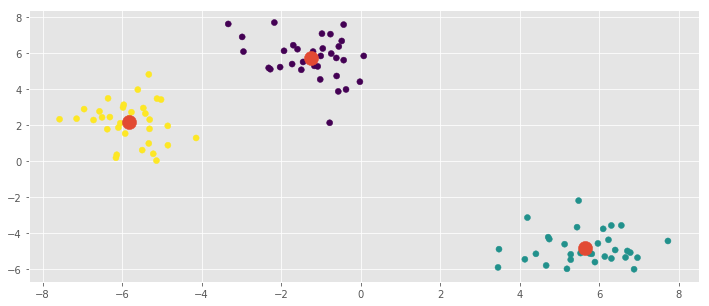

In [5]:
## Работоспособность KMeans
test_Kmeans = KMeans(k=3, init='random', random_state=8)
test_Kmeans.fit(X)
y_test_KMeans = test_Kmeans.predict(what='y')
C_test_KMeans = test_Kmeans.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_KMeans)
plt.scatter(C_test_KMeans[:,0], C_test_KMeans[:,1], s=200)
plt.show()

### KMeans++:

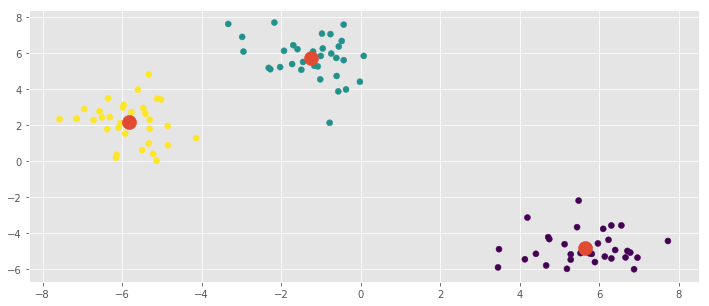

In [6]:
## Работоспособность KMeans++
test_KmeansPP = KMeans(k=3, init='k-means', random_state=20)
test_KmeansPP.fit(X)
y_test_KMeansPP = test_KmeansPP.predict(what='y')
C_test_KMeansPP = test_KmeansPP.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_KMeansPP)
plt.scatter(C_test_KMeansPP[:,0], C_test_KMeansPP[:,1], s=200)
plt.show()

### KMeans с MiniBatchKMeans

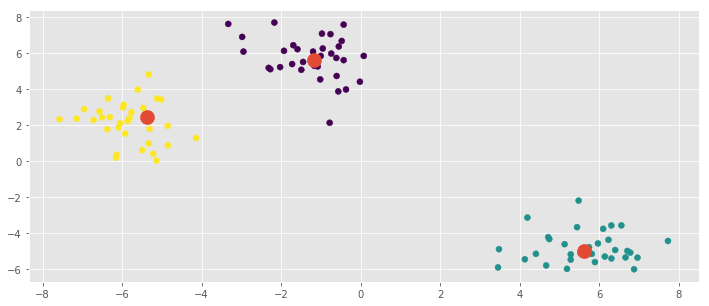

In [7]:
## Работоспособность KMeans с MiniBatchKMeans
test_MiniBatchKMeans = MiniBatchKMeans(k=3, init='random', random_state=14, max_iter=1000, batchSize=25)
test_MiniBatchKMeans.fit(X)
y_test_MiniBatchKMeans = test_MiniBatchKMeans.predict(what='y')
C_test_MiniBatchKMeans = test_MiniBatchKMeans.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_MiniBatchKMeans)
plt.scatter(C_test_MiniBatchKMeans[:,0], C_test_MiniBatchKMeans[:,1], s=200)
plt.show()


В этом методе, так же как и в KMeans возможна сходимость к неправильному решению, например:


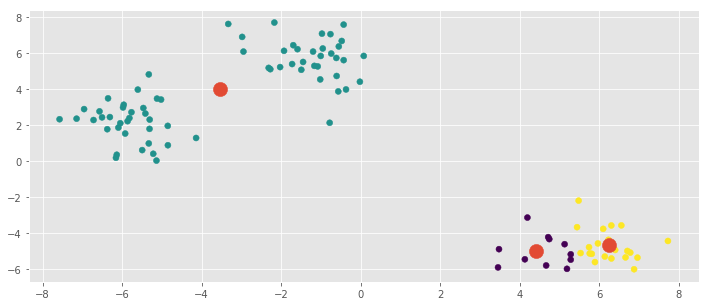

In [8]:
## Работоспособность KMeans с MiniBatchKMeans
test_MiniBatchKMeans2 = MiniBatchKMeans(k=3, init='random', random_state=13)
test_MiniBatchKMeans2.fit(X)
y_test_MiniBatchKMeans2 = test_MiniBatchKMeans2.predict(what='y')
C_test_MiniBatchKMeans2 = test_MiniBatchKMeans2.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_MiniBatchKMeans2)
plt.scatter(C_test_MiniBatchKMeans2[:,0], C_test_MiniBatchKMeans2[:,1], s=200)
plt.show()

Эта проблема исправлена в методах с KMeans++

### KMeans++ с MiniBatchKMeans:

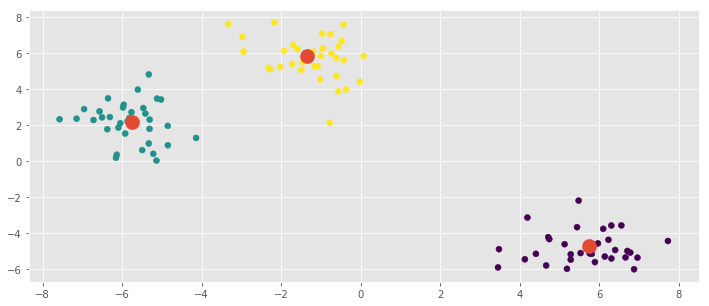

In [9]:
## Работоспособность KMeans с MiniBatchKMeans
test_MiniBatchKMeansPP = MiniBatchKMeans(k=3, init='k-means', random_state=13)
test_MiniBatchKMeansPP.fit(X)
y_test_MiniBatchKMeansPP = test_MiniBatchKMeansPP.predict(what='y')
C_test_MiniBatchKMeansPP = test_MiniBatchKMeansPP.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_MiniBatchKMeansPP)
plt.scatter(C_test_MiniBatchKMeansPP[:,0], C_test_MiniBatchKMeansPP[:,1], s=200)
plt.show()

# Время выполнения алгоритмов

In [10]:
import time

#случайные кластеры точек
X1, y1 = make_blobs(n_samples=10000, n_features=2, centers=3, cluster_std=0.7, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

#меряем с разным числом точек
N = np.array([100, 250, 500, 1000, 2500, 5000, 10000])
Time = np.zeros(N.size)


## Kmeans:

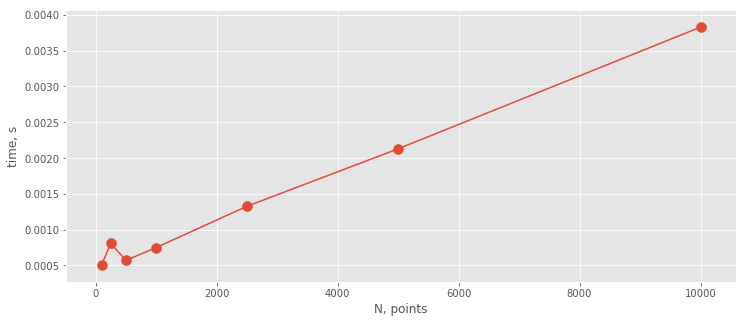

In [11]:
## Время выполнения алгоритма KMeans
time_KMeans = KMeans(k=3, init='random', eps=0.01)
for i in xrange(N.size):
    ind = np.random.choice(xrange(10000), N[i], replace=False)
    X_test = X1[ind,:]
    start = time.time()
    time_KMeans.fit(X_test)
    end = time.time()
    Time[i] = end - start
    
plt.plot(N, Time)
plt.scatter(N,Time, s=100)
plt.ylabel('time, s')
plt.xlabel('N, points')
plt.show()

## KMeans++:

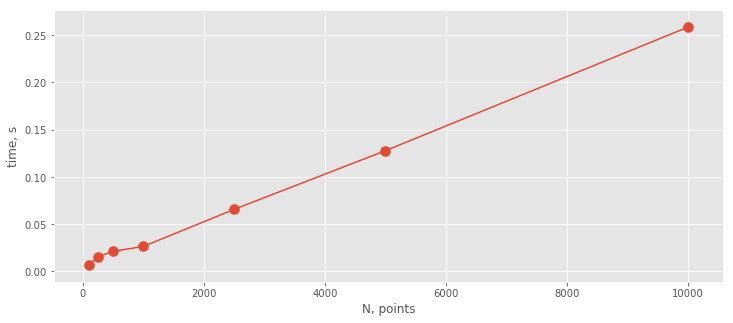

In [12]:
## Время выполнения алгоритма KMeans++
time_KMeansPP = KMeans(k=3, init='k-means')
for i in xrange(N.size):
    ind = np.random.choice(xrange(10000), N[i], replace=False)
    X_test = X1[ind,:]
    start = time.time()
    time_KMeansPP.fit(X_test)
    end = time.time()
    Time[i] = end - start
    
plt.plot(N, Time)
plt.scatter(N,Time, s=100)
plt.ylabel('time, s')
plt.xlabel('N, points')
plt.show()

## KMeans с MiniBatchKMeans:

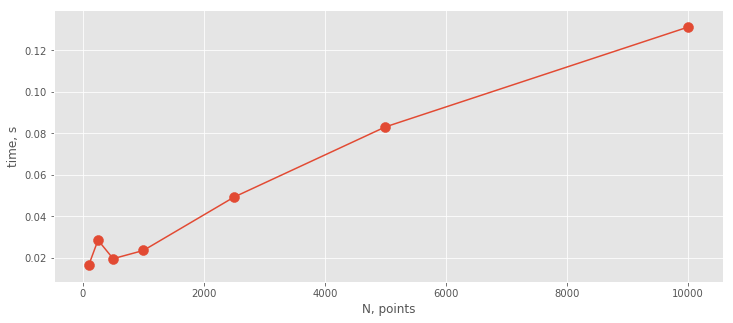

In [13]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
time_MiniBatchKMeans = MiniBatchKMeans(k=3, init='random')
for i in xrange(N.size):
    ind = np.random.choice(xrange(10000), N[i], replace=False)
    X_test = X1[ind,:]
    start = time.time()
    time_MiniBatchKMeans.fit(X_test)
    end = time.time()
    Time[i] = end - start
    
plt.plot(N, Time)
plt.scatter(N,Time, s=100)
plt.ylabel('time, s')
plt.xlabel('N, points')
plt.show()


## KMeans++ с MiniBatchKMeans:

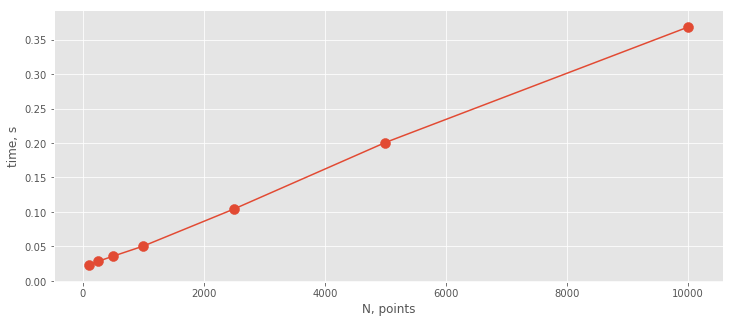

In [14]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
time_MiniBatchKMeansPP = MiniBatchKMeans(k=3, init='k-means')
for i in xrange(N.size):
    ind = np.random.choice(xrange(10000), N[i], replace=False)
    X_test = X1[ind,:]
    start = time.time()
    time_MiniBatchKMeansPP.fit(X_test)
    end = time.time()
    Time[i] = end - start
    
plt.plot(N, Time)
plt.scatter(N,Time, s=100)
plt.ylabel('time, s')
plt.xlabel('N, points')
plt.show()

# Применение Kmeans на реальных данных

In [15]:
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',').dropna()
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2006,F,18.930,72,0,0,0,0,0,0,...,0,2,0,0,2,0,0,0,0,0


In [16]:
#извлекаем матрицу признаков
df = df_sns.loc[:,'basketball':'drugs'].as_matrix()
df.shape

(24005, 36)

In [17]:
#нормализация
df = (df - df.mean(axis=0))/df.std(axis=0)

In [18]:
df

array([[-0.33957553, -0.36936768, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [-0.33957553,  1.01800067, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [-0.33957553,  1.01800067, -0.2455023 , ...,  2.00223527,
        -0.22425649, -0.1770471 ],
       ..., 
       [-0.33957553,  1.01800067, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [-0.33957553, -0.36936768, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [ 2.11643849, -0.36936768, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ]])

## Kmeans:

In [19]:
## KMeans
stud_KMeans = KMeans(k=9, init='random', eps=0.01)
stud_KMeans.fit(df)
y_stud_KMeans = stud_KMeans.predict(what='y')
C_stud_KMeans = stud_KMeans.predict(what='centroids')

In [20]:
#число членов кластеров
pd.DataFrame(data=y_stud_KMeans)[0].value_counts()

1    13891
8     2525
5     2448
6     1281
7      927
2      816
4      782
3      682
0      653
Name: 0, dtype: int64

## Kmeans++:

In [21]:
## KMeans++
stud_KMeansPP = KMeans(k=9, init='k-means', eps=0.01)
stud_KMeansPP.fit(df)
y_stud_KMeansPP = stud_KMeansPP.predict(what='y')
C_stud_KMeansPP = stud_KMeansPP.predict(what='centroids')

In [22]:
#число членов кластеров
pd.DataFrame(data=y_stud_KMeansPP)[0].value_counts() 

7    16726
1     2658
0     1819
6     1288
3      849
4      348
2      285
5       31
8        1
Name: 0, dtype: int64

## KMeans с MiniBatchKMeans:

In [23]:
## KMeans с MiniBatchKMeans
stud_MiniBatchKMeans = MiniBatchKMeans(k=9, init='k-means', eps=0.01, batchSize=1000)
stud_MiniBatchKMeans.fit(df)
y_stud_MiniBatchKMeans = stud_MiniBatchKMeans.predict(what='y')
C_stud_MiniBatchKMeans = stud_MiniBatchKMeans.predict(what='centroids')

In [24]:
#число членов кластеров
pd.DataFrame(data=y_stud_MiniBatchKMeans)[0].value_counts()

8.0    17264
2.0     3040
0.0     2715
7.0      803
1.0      183
Name: 0, dtype: int64

## KMeans++ с MiniBatchKMeans:

In [25]:
## KMeans++ с MiniBatchKMeans
stud_MiniBatchKMeansPP = MiniBatchKMeans(k=9, init='k-means', eps=0.01, batchSize=1000)
stud_MiniBatchKMeansPP.fit(df)
y_stud_MiniBatchKMeansPP = stud_MiniBatchKMeansPP.predict(what='y')
C_stud_MiniBatchKMeansPP = stud_MiniBatchKMeansPP.predict(what='centroids')

In [26]:
#число членов кластеров
pd.DataFrame(data=y_stud_MiniBatchKMeansPP)[0].value_counts()

8.0    17264
2.0     3040
0.0     2715
7.0      803
1.0      183
Name: 0, dtype: int64

### Результаты:
Некоторые кластеры очень маленькие и их сложно найти, особенно алгоритмами MiniBatchKMeans. Нужно брать маленький eps - критерий прикращения счета, что делает расчет очень долгим. Будем рассматривать кластеры, полученные алгоритмом KMeans++. Теперь рассмотрим все кластеры

In [27]:
#выделим названия колонок
interests = list(df_sns.loc[:,'basketball':'drugs'].columns.values)
interests

['basketball',
 'football',
 'soccer',
 'softball',
 'volleyball',
 'swimming',
 'cheerleading',
 'baseball',
 'tennis',
 'sports',
 'cute',
 'sex',
 'sexy',
 'hot',
 'kissed',
 'dance',
 'band',
 'marching',
 'music',
 'rock',
 'god',
 'church',
 'jesus',
 'bible',
 'hair',
 'dress',
 'blonde',
 'mall',
 'shopping',
 'clothes',
 'hollister',
 'abercrombie',
 'die',
 'death',
 'drunk',
 'drugs']

In [28]:
#координаты центроидов для каждого кластера
Cluster = np.zeros((9,36))
for i in xrange(9):
    Cluster[i,:] = C_stud_KMeansPP[i,:]

Cluster #0


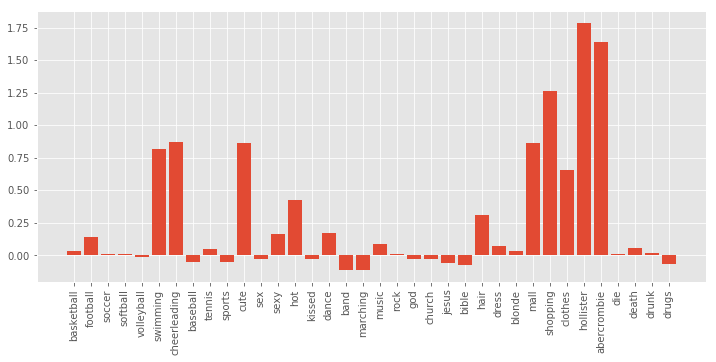

Cluster #1


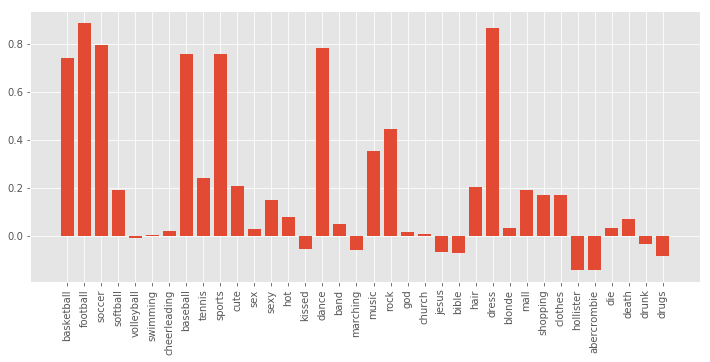

Cluster #2


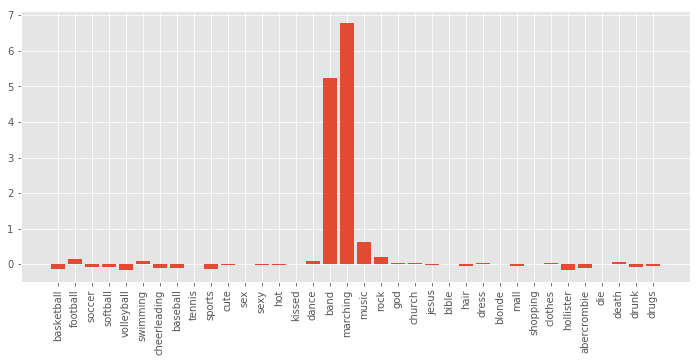

Cluster #3


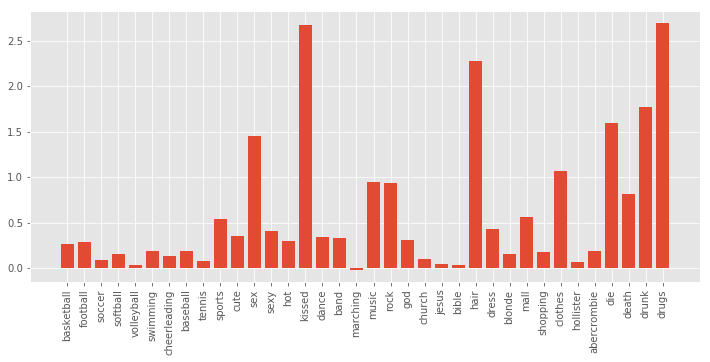

Cluster #4


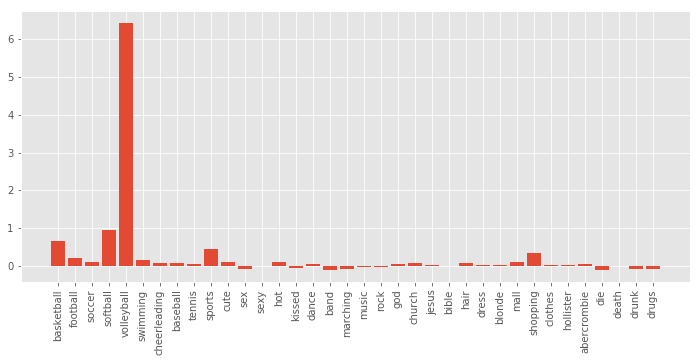

Cluster #5


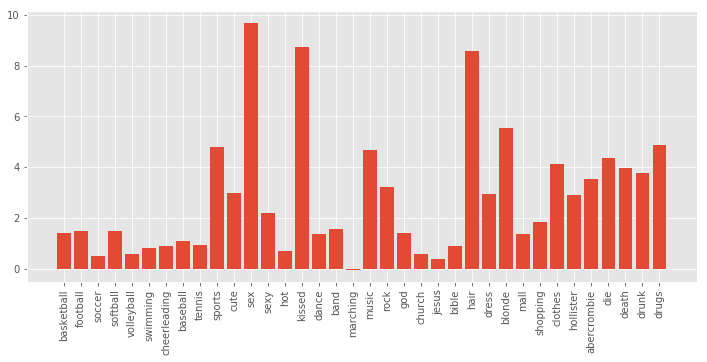

Cluster #6


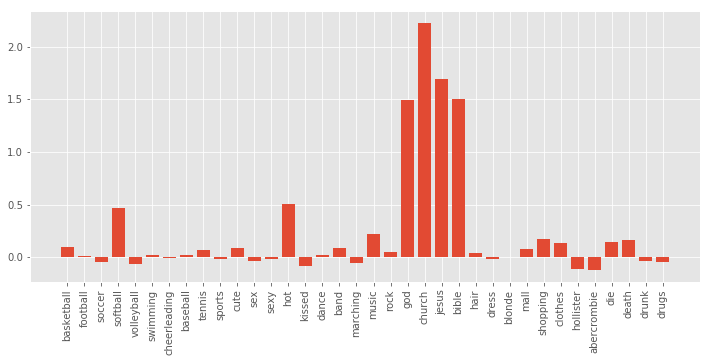

Cluster #7


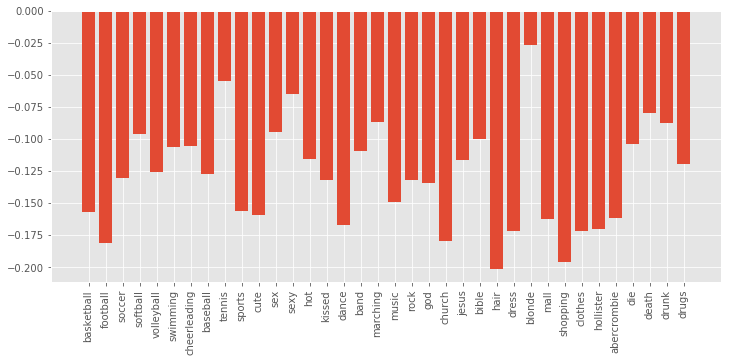

Cluster #8


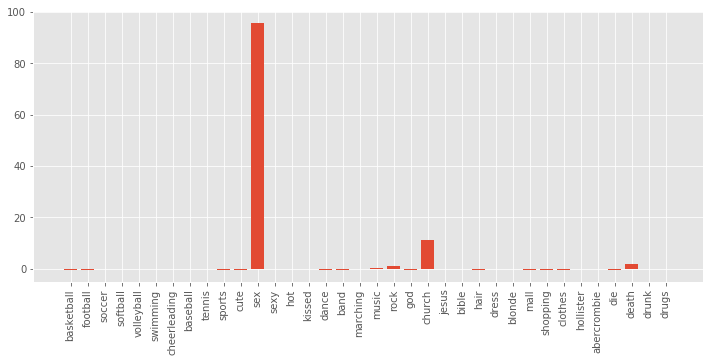

In [29]:
for i in xrange(9):
    print "Cluster #%(i)d" % {"i":i}
    plt.bar( xrange(36), Cluster[i])
    plt.xticks(xrange(36) ,interests, rotation=90 )
    plt.show()


## Вывод:
<p>В задании реализованы и проанализированы алгоритмы кластеризации данных, расмотрены их преимущества и недостатки. Алгоритм KMeans требует больше операций, но стабильнее MiniBatchKMeans, но есть проблема - при некоторых начальных положениях центроидов он может сходится неправильно. Это проблема исправлена в KMeans++, который чуть более трудоемкий. Алгоритм MiniBatchKMeans с KMeans требует меньше времени, но менее стабилен при большом количестве кластеров или при наличии маленьких кластеров. Алгоритм MiniBatchKMeans c KMeans++ работает стабильнее. </p> 
<p>Алгоритмы были применены к данным с описанием интересов учеников.Лучшие результаты показали алгоритмы KMeans. Чтобы проанализировать результаты рассмотрим расположение центров кластеров в пространстве, где каждое измерение - указанный в профиле интерес в какой-то области. По этим результатам большую часть учеников можно разделить на группы по интересам. Например, те, кто попал в кластер #1 интересуются шопингом, одеждой, прическами и черлидингом. В кластере #2 находятся люди, интересующиеся религией. В #3 интересуются спортом, танцами и шопингом. Члены класса #4 очень любят алкоголь. Попавшие в класс #7 скорее всего являются членами марширующего оркестра. Полученные результаты могут быть использованы для для анализа интересов молодежи и для, например, показа таргетированной рекламы.</p>